In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

In [3]:
df_size = 100000
ds = tfds.load('sentiment140', split='train', shuffle_files=True)
df = tfds.as_dataframe(ds.take(df_size))
df.sample(2)

,date,polarity,query,text,user
71042,b'Sat Jun 06 07:23:17 PDT 2009',4,b'NO_QUERY',"b""I wasn't expecting it to grow, but it did! S...",b'wolfblaze'
41894,b'Sat May 30 09:24:42 PDT 2009',0,b'NO_QUERY',b'stressing out ',b'Jenne0187'


In [4]:
len(df)

100000

In [5]:
df['polarity'].value_counts()

4    50021
0    49979
Name: polarity, dtype: int64

---
##### Note: Binary classification can be used. 



In [6]:
df['bin_polarity'] = df['polarity'].apply(lambda x: 1 if x == 4 else 0)

The structure of the RNN is that we take just the output of the final word (unless we're doing a bidirectional format, or a concatenated format where we concatenate the output of all the words)

---

#### Creating X values

The text is in byte form, so we need to convert it to string form, and then use the split functionality to convert to a list. We ignore the first two characters which are a side effect of the conversion, and the last element in the string which is the same

In [7]:
print(f'columns names: {list(df.columns)}')

columns names: ['date', 'polarity', 'query', 'text', 'user', 'bin_polarity']


In [59]:
## separating the words into a list of words
df['split_words'] = df['text'].apply(lambda x: str(x.lower())[2:].split()[:-1])
df['split_words'] = df['split_words'].apply(lambda x: [x.translate(str.maketrans('', '', string.punctuation)) for x in x])

In [10]:
# ## Get the length of words
# df['txt_length'] = df['split_words'].apply(lambda x: len(x))

In [9]:
# df['txt_length'].value_counts(bins=10)

----
Very few tweets are over 30 words, so we will create an RNN based on 30 words

We now need to create a words dictionary

In [10]:
Tx = 30 #this is the value we use to specify how many words to consider in the tweet (first e.g. 30)

In [13]:
df['split_words']

0            [ouch!, i, just, burned, my, finger, so, bad]
1        [im, so, happy, i, found, some, one, who, want...
2                       [@mceeyoshi, that's, my, movie, !]
3                [my, sister, is, taking, over, my, room!]
4                           [i, really, suck, at, pinball]
                               ...                        
99995    [i, want, the, sun, to, come, out!, why, does,...
99996    [tuesday., another, infinite, crisis, at, the,...
99997               [finally, my, picture, is, working...]
99998                [it'll, all, be, ok.., til, thursday]
99999    [@iphonetalktoday, have, an, ipod, touch, 32gb...
Name: split_words, Length: 100000, dtype: object

In [69]:
'''create words dict'''

no_words = 5000
def create_words_dict(df,no_words):
    
    top_words = list(df['split_words'].explode().value_counts()[:no_words].index)
    word_dict = {}
    for idx, word in enumerate(top_words):
        word_dict[idx+1] = word

    #create additional values for 'word is over' and 'unknown'
    word_dict[no_words+1] = 'word_over'
    word_dict[0] = 'UNKNOWN-WORD'

    #create reversed dict
    word_dict_reversed = {}
    for key, value in word_dict.items():
        word_dict_reversed[value] = key
    
    return word_dict, word_dict_reversed
word_dict_2k, word_dict_reversed = create_words_dict(df,no_words)

---
##### Our X values need to be vocab_size x 30 x m, one hot encoded

In [70]:
#getting the words in numeric index format
    
def create_x_array(df,Tx,no_words):
    x = df['split_words'].apply(lambda x: np.array([word_dict_reversed[word] if word in word_dict_reversed.keys() else 0 for word in x]))

    '''we're going to make all the x values the same length'''

    array_x = np.zeros((df_size,Tx)) #blank array to put them in
    for idx,arr in enumerate(x):
        leng = len(arr) 
        #get length, and fork based on current size
        if leng > Tx:
            array_x[idx] = arr[:Tx] #just take first 30 values
        elif leng < Tx:
            array_x[idx] = np.append(arr,np.zeros(Tx-leng)+no_words+1) #append 30 minus the current length -1s
    #put examples on the columns
    array_x = array_x.T
    return array_x,x


array_x,x = create_x_array(df,Tx=30,no_words=no_words)

In [71]:
array_x.shape

(30, 100000)

In [72]:
'''Now one hot encode them'''
def one_hot_process(array_x,Tx, batch_size):
    one_hot_x_40k = np.zeros((no_words+2,Tx,batch_size))
    for row_idx, row in enumerate(array_x[:,:batch_size]):
        for exam_idx, word_val in enumerate(row):
            one_hot_x_40k[int(word_val),row_idx,exam_idx] = 1
    return one_hot_x_40k
def mask_process(array_x, batch_size,no_words):
    return np.where(array_x[:,:batch_size]==no_words+1,1,0)
def one_hot_and_mask(array_x, Tx, batch_size,no_words):
    one_hot_x_40k = one_hot_process(array_x,Tx, batch_size)
    mask_x = mask_process(array_x, batch_size,no_words)
    return one_hot_x_40k, mask_x

In [73]:
one_hot_x_40k = one_hot_process(array_x,Tx, 10000)


---
We've used 2002 in order to incorporatate the 2001th word (end of word) and unknown index. We can need to create a mask which tells the machine to skip if the mask is positive

In [74]:
mask_x  = mask_process(array_x, 10000,10000)

In [75]:
mask_x.shape

(30, 10000)

In [89]:
#Turn Y into an array
Y = np.array(df['bin_polarity']).reshape(1,-1)

----
OK so we have our x inputs. Mask x, shaped 30 x 40000, and the actual onehotencoded x values, of shape 2001, 30, 40000

In the basic RNN, ignoring the last stage for a second, each cell has three weights matrixes.

### Forward Prop

WAa - the weights applied to the previous cells outputs

WAx - the weights applied to the X values

WaB - a bias term. 

We have to make a choice of how large each cell is, and then initialise the weights. We'll use a Xavier initialization for now

In [79]:
#try a cell size of 50
cell_size = 50
x_size = no_words+no_words #Xavier_initialization of weights.
WAa = np.random.uniform(-(6)/(np.sqrt(cell_size*2)),(6)/((cell_size*2)),[cell_size,cell_size]) 
WAb = np.random.uniform(-(6)/(np.sqrt(cell_size+1)),(6)/((cell_size+1)),[cell_size,1]) 
WAx = np.random.uniform(-(6)/(np.sqrt(cell_size+x_size)),(6)/((cell_size+x_size)),[cell_size,x_size]) 

#We need a weights matrix too for later
WYa = np.random.uniform(-(6)/((cell_size+1)),(6)/((cell_size+1)),[1,cell_size])
WYb = np.random.uniform(-(6)/((1+1)),(6)/((1+1)),[1,1])

weights_dict = {}
weights_dict['WAa'] = WAa
weights_dict['WAb'] = WAb
weights_dict['WAx'] = WAx
weights_dict['WYa'] = WYa
weights_dict['WYb'] = WYb


---
Now let's implement one run of forward prop in order to replicate it going forward

In [80]:
#these allow us to set some default values
a0 = np.zeros((cell_size,df_size))
z_dict, a_dict = {}, {}
a_dict[0] = a0

In [81]:
'''See notes from above - this is just implemented as a function'''
def forward_prop(a_prev,  WAa, WAx, WAb, x, mask,time_period=0):
    
    # #z1 - the pre-tanh values of a0, bias and x1 times weights
    z1 = WAa @ a_prev + WAx @ x[:,time_period,:] + WAb
    
    # #a1 either equals a1 if mask ==1 or equal tanh z1 if mask == - 
    a1 = mask[time_period].reshape(1,-1) * a_prev + (1-mask[time_period]) * np.tanh(z1)
    
    return a1, z1

---
The idea here is to loop over the time periods and run forward prop each time. We will need to re-use a1 and z1 when we come back and do the back prop, so we will store them in a dictionary

In [82]:
def cells_fw_prop(Tx, z_dict, a_dict, a0,WAa, WAx, WAb, x, mask):
    a_prev = a0 #to have an initial value to call the forward_prop function
    for i in range(Tx):
        a_, z_ = forward_prop(a_prev=a_prev, time_period = i,x=x,mask = mask,WAa=WAa, WAx=WAx, WAb=WAb)
        z_dict[i+1], a_dict[i+1] = z_, a_
        a_prev = a_
    #we end by returning the dictionary for z and a values throughout the time period
    return z_dict, a_dict 

---
##### Lets put it all together in a forward prop function

In [83]:
def sigmoid(Yz):
        return (1/(1+np.exp(-Yz)))
    
def full_fw_prop(weights_dict, z_dict, a_dict, x, mask, Tx = Tx):
    
    # initialize a0 and dict values
    a0 = np.zeros((cell_size, x.shape[2]))
    a_dict[0] = a0
    WAa, WAb, WAx, WYa, WYb = weights_dict.values()

    #do the cell forward prop    
    z_dict, a_dict = cells_fw_prop(Tx = Tx, z_dict=z_dict, a_dict=a_dict, a0=a0,WAa=WAa, WAx=WAx, WAb=WAb, x=x,mask=mask)

    #extract last value and prediction
    final_a = a_dict[Tx]
    Yz = WYa @ final_a + WYb
   
    Ÿ = sigmoid(Yz)

    return z_dict, a_dict, Yz, Ÿ

----
### Back Propogation

We can conveniently use the differentiated sigmoid function, which gives

DL/DZ = Ÿ - Y

From there we can initially back calculate the values of the final portion, giving values for DL/DA, DL/DWYa, DL/DWYb

In [324]:
# #Turn Y into an array
Y = np.array(df['bin_polarity']).reshape(1,-1)

In [85]:
#let's start by initializing the backprop dicts
dA_dict, dZ_dict = {}, {}

---
OK let's create the relevant functions

In [86]:
def back_prop_one_layer(prev_Loss, t, weights_dict,  a_dict,z_dict,  X, mask_x,learning_rate = 0.01,batch_size=400):
    
    WAa, WAb, WAx, WYa, WYb = weights_dict.values()
    a_ = a_dict[t]
    z_ = z_dict[t]
    a__ = a_dict[t-1]
    x_ = X[:,t-1,:]

    #get dA and dZ as a base for the layer
    dL_dA = prev_Loss #40000,50
    dA_dZa = ((1-mask_x[t-1]) * (1-(np.tanh(z_)**2))).T #40000,50
    
    #get a previous
    dZ_dAp = WAa #50x50
    dA_dAp = mask_x[t-1].reshape(-1,1) + np.zeros_like((dL_dA)) + (dA_dZa @ dZ_dAp) #we create a mask of 1s everywhere here.
    dL_dAp = dL_dA * dA_dAp

    #differentiate with respect to weights
    dZ_dWAa = a__ #50 x m
    dL_dWAa = ((dL_dA * dA_dZa).T @ dZ_dWAa.T)/batch_size #weights dont matter if we are having a 0 on the mask

    dZ_dWAb = np.zeros((batch_size,1))+1
    dL_dWAb = ((dL_dA * dA_dZa).T @ dZ_dWAb)/batch_size

    dZ_dWAx = x_
    dL_dWAx = ((dL_dA * dA_dZa).T @ dZ_dWAx.T)/batch_size #weights dont matter if we are having a 0 on the mask
    
    #now update the weights based on the findings here.
    return dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp

In [87]:
def back_prop_full_swing(Ÿ, Y, Tx, weights_dict,  a_dict,z_dict,  X, mask_x,learning_rate = 0.01,batch_size = 100):
    
    '''initial loss function w.r.t Z'''
    WAa, WAb, WAx, WYa, WYb = weights_dict.values()
    dL_dZ = (Ÿ - Y).T #40000 x 1


    # first order diffs
    dZ_dA = WYa # 1 x 50
    dZ_dWYa = a_dict[Tx] # 50 x 40000
    dZ_dB = np.zeros_like(dL_dZ) + 1

    #chain ruled diffs
    dL_dA = dL_dZ @ dZ_dA
    dL_dWYa = (dZ_dWYa @ dL_dZ).T / batch_size
    dL_dWYb = (dZ_dB.T @ dL_dZ)/ batch_size
    
    weights_dict['WYa'] -= learning_rate * dL_dWYa
    weights_dict['WYb'] -= learning_rate * dL_dWYb
    
    prev_loss = dL_dA
    '''now go through the other functions'''
    for t in reversed(range(1,Tx)):
        #extract relevant differentials for updating backprop and also carrying on the backprop through the layers
        dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp = back_prop_one_layer(prev_Loss=prev_loss, t=t, weights_dict = weights_dict,X=x,  a_dict=a_dict,z_dict=z_dict,mask_x=mask_x,batch_size=batch_size)
        weights_dict['WAa'] -= learning_rate*dL_dWAa
        weights_dict['WAx'] -= learning_rate*dL_dWAx
        weights_dict['WAb'] -= learning_rate*dL_dWAb
        prev_loss = dL_dAp
        return dL_dZ, dZ_dA, dZ_dB, dL_dA, dL_dWYa, dL_dWYb, dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp

In [88]:
# back_prop_full_swing(Ÿ=Ÿ, Y=Y, Tx=Tx, weights_dict=weights_dict,  a_dict=a_dict,z_dict=z_dict,  X=one_hot_x_40k, mask_x=mask_x,learning_rate = 0.01)

---

#### Putting it all together

Let's now create a function which runs forward prop and backward prop in batches, and calculates the loss at each time

In [93]:
'''set some initial parameters'''
epochs = 500
cell_size = 64
x_size = no_words+2
batches=1000
batch_size = int(df_size//batches) #so 400
loss_reporting_frequency = 200

''' initialize weights'''
def RNN_init(cell_size, x_size):
    WAx = np.random.uniform(-1,1,[cell_size,x_size])
    WAb = np.random.uniform(-1,1,[cell_size,1])
    WAa = np.random.uniform(-0.1,0.1,[cell_size,cell_size])
    WYa = np.random.uniform(-0.25,0.25,[1,cell_size])
    WYb = np.random.uniform(-1,1,[1,1])
    weights_dict = {}
    weights_dict['WAa'] = WAa
    weights_dict['WAb'] = WAb
    weights_dict['WAx'] = WAx
    weights_dict['WYa'] = WYa
    weights_dict['WYb'] = WYb
    z_dict, a_dict= {}, {}
    losses, accs,  ys, y_hats = [],[],[],[]
    return WAx, WAb, WAa, WYa, WYb, weights_dict, z_dict, a_dict, losses, accs, ys, y_hats

def batching_rnn(epoch,batches, batch_size):
    round_ = epoch % batches #deals with if it's the first of a new set of batches
    n, k = batch_size*round_, batch_size*(1 + round_)
    return n,k 

def get_loss_metrics_rnn(y,Ÿ,batch_size, epoch,k):
    loss = -np.sum(y*np.log(Ÿ) + (1-y)*np.log(1-Ÿ))/batch_size
    ys.append(y)
    y_hats.append(Ÿ)
    accuracy = np.sum(y==np.where(Ÿ>0.5,1,0))/batch_size
    losses.append(loss)
    accs.append(accuracy)
    if epoch % k == 0:
        print(f'Accuracy score: {np.mean(accs[(epoch-batch_size):])}')    
        print(f'Epoch: {epoch}, loss: {loss}')

WAx, WAb, WAa, WYa, WYb, weights_dict, z_dict, a_dict, losses, accs, ys, y_hats = RNN_init(cell_size,x_size)        
for epoch in range(epochs):
    n, k = batching_rnn(epoch,batches,batch_size) #create batching indexes

    #get specific x and y values
    x, mask_x_ = one_hot_and_mask(array_x[:,n:k],Tx,batch_size,no_words=no_words)
    y = Y[0,n:k]
    
    #run fw prop
    z_dict, a_dict, Yz, Ÿ = full_fw_prop(Tx = Tx, z_dict=z_dict, a_dict=a_dict, weights_dict = weights_dict, x=x,mask=mask_x_)
    
    #append metrics and print loss if relevant
    get_loss_metrics_rnn(y,Ÿ, batch_size, epoch, loss_reporting_frequency)
    
    #run backprop
    dL_dZ, dZ_dA, dZ_dB, dL_dA, dL_dWYa, dL_dWYb, dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp = back_prop_full_swing(Ÿ=Ÿ, Y=y, Tx=Tx, weights_dict=weights_dict,  a_dict=a_dict,z_dict=z_dict,  X=x, mask_x=mask_x_,learning_rate = 0.1,batch_size = batch_size)

Accuracy score: 0.48
Epoch: 0, loss: 0.7342162588514232
Accuracy score: 0.5299009900990099
Epoch: 200, loss: 0.68143362146241
Accuracy score: 0.5348514851485149
Epoch: 400, loss: 0.6875637372372094


In [340]:
a_dict[30]

array([[-0.12135689, -0.71660081,  0.23251359, ...,  0.17323553,
        -0.87838207,  0.37504349],
       [-0.88134366, -0.90306568, -0.94579807, ..., -0.67807376,
         0.02865951,  0.25115641],
       [-0.74451552, -0.46015606,  0.47691773, ..., -0.19210396,
        -0.75220213,  0.31057394],
       ...,
       [-0.31304665,  0.00483609, -0.70442376, ...,  0.49018579,
         0.8468961 ,  0.81864161],
       [ 0.63358706, -0.85337845,  0.63464234, ..., -0.21338884,
        -0.62683255, -0.18111244],
       [ 0.63527926,  0.6289208 ,  0.96180813, ..., -0.10453993,
        -0.0856621 ,  0.40286678]])

---
We see a small amount of ability from the model to predict sentiment.

#### GRU

We'll use the same format, albeit with different functions to build a GRU

In [215]:
'''Weights initialisation'''
def weights_initialisation(batch_size,cell_size=50,x_size=2002):
    #initialise the weights for the main 'estimator' node
    weights={}
    weights['gWCx'] = np.random.uniform(-1,1,[cell_size, x_size])
    weights['gWCc'] = np.random.uniform(-1,1,[cell_size, cell_size])
    weights['gWCb'] = np.random.uniform(-1,1,[cell_size,1])

    #initialize weights for the 'update' node
    weights['gWUx'] = np.random.uniform(-1,1,[cell_size, x_size])
    weights['gWUc'] = np.random.uniform(-1,1,[cell_size, cell_size])
    weights['gWUb'] = np.random.uniform(-1,1,[cell_size,1])

    #initalise weights for output layer
    weights['gWYa'] = np.random.uniform(-0.25,0.25,[1,cell_size])
    weights['gWYb'] = np.random.uniform(-1,1,[1,1])
    
    a0 = np.zeros((cell_size, batch_size)) #create blank a0
    return weights, a0

def dict_initialisation_gru():
    zc_dict, zu_dict, č_dict, cupd_dict, c_dict = {}, {}, {}, {}, {}
    return zc_dict, zu_dict, č_dict, cupd_dict, c_dict

In [189]:
def gforward_prop_1(c_prev, weights, x, mask, t=0):
    gWCx, gWCc, gWCb, gWUx, gWUc, gWUb, _, _ = weights.values()
    
    #create value for č by creating a z value to be tanhd + b
    
    zc = gWCx @ x[:,t,:] + gWCc @ c_prev + gWCb
    č = np.tanh(zc)
    
    #now create a value for c_update, and use mask to make this 0 if the mask is on.
    zu = gWUx @ x[:,t,:] + gWUc @ c_prev + gWUb 
    Cupd = (1-mask[t]) * sigmoid(zu) #this will be zero if mask is 1
    
    #now update c
    c = Cupd * č + (1-Cupd) * c_prev
    
    return zc, č, zu, Cupd, c

In [190]:
def gcells_fw_prop(zc_dict, zu_dict, č_dict, cupd_dict, c_dict, a0, weights, x, mask,Tx):
    
    c_prev = a0 #to have an initial value to call the forward_prop function
    for t in range(Tx):
        zc, č, zu, Cupd, c = gforward_prop_1(c_prev=c_prev, t = t,x=x,mask = mask, weights=weights)
        zc_dict[t+1], č_dict[t+1], zu_dict[t+1], cupd_dict[t+1], c_dict[t+1] = zc, č, zu, Cupd, c
        c_prev = c
    #we end by returning the dictionary for z and a values throughout the time period
    return zc_dict, zu_dict, č_dict, cupd_dict, c_dict

In [191]:
def gfull_fw_prop(a0, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask, Tx = Tx):
    
    #do the cell forward prop    
    zc_dict, zu_dict, č_dict, cupd_dict, c_dict = gcells_fw_prop(zc_dict, zu_dict, č_dict, cupd_dict, c_dict, a0, weights, x, mask,Tx)

    #extract last value and prediction
    final_c = c_dict[Tx]
    Yz = weights['gWYa'] @ final_c + weights['gWYb']
    Ÿ = sigmoid(Yz)

    return zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ

In [192]:
def sigmoid(Yz):
        return (1/(1+np.exp(-Yz)))

---

#### unit tests

In [51]:
one_hot_x_40k

(5002, 30, 10000)

In [193]:
#when i initialise the weights, with a different x size, gWCx gives that value. same with cell size
x_size_ut = 5002
c_size_ut = 50
batch_size= 1000
x_ut, mask_x_ut = one_hot_x_40k[:,:,:batch_size], mask_x[:,:batch_size]
y_ut = Y[:,:batch_size]

weights_ut,a0= weights_initialisation(cell_size=c_size_ut,x_size=x_size_ut,batch_size=batch_size)
assert weights_ut['gWUx'].shape == (c_size_ut, x_size_ut)

#when i call the main function, c_dict[30] should be numbers with mean ~ 0 and var [0.25,1.25]
zc_dict, zu_dict, č_dict, cupd_dict, c_dict = dict_initialisation_gru()
zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ = gfull_fw_prop(a0, weights_ut, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x_ut, mask_x_ut, Tx)

assert abs(np.mean(c_dict[30])) < 0.1
assert 0.25 < np.var(c_dict[30]) < 1.25

print(f'Mean: {np.mean(c_dict[30])}\nVariance: {np.var(c_dict[30])}')

Mean: 0.010948738591262427
Variance: 0.7115851806965051


---
Alright now we're burning diesel.

Time for back prop...

In [194]:
def gback_prop_one_layer(prev_loss, t, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict,  x, mask_x,learning_rate = 0.01,batch_size=400):
    
    gWCx, gWCc, gWCb, gWUx, gWUc, gWUb, gWYa, gWYb = weights.values()
    zc, zu, č, cupd, c = zc_dict[t], zu_dict[t], č_dict[t], cupd_dict[t], c_dict[t]
    c_ = c_dict[t-1] #also take the last c value frm previous round for differentials
    x_ = x[:,t-1,:] #relevant x values, 2000 x m

    dl_dc = prev_loss #m,50

    '''first backpropogate through to get c previous'''
    dc_dč = cupd #50 x m 
    dc_dcupd = č - c_ #50 x m
    dč_dzc = 1 - np.tanh(zc)**2 #50 x m
    dcupd_dzu = sigmoid(zu) * (1-sigmoid(zu)) #50 x m
    dzc_dc_1 = gWCc #50,50
    dzu_dc_1 = gWUc #50,50

    #1- cupd is 50, m
    dc_dc_1 = (1-cupd).T + ((dc_dč * dč_dzc).T @ gWCc) + ((dc_dcupd * dcupd_dzu).T @ gWUc) #ends as 50 x m 
    dl_dc_1 = dl_dc * dc_dc_1 #m x 50

    
    '''now get the weights with respect to L'''
    #first three terms are element wise because they are the ru term and the sigmoid term.

    dL_dWCx = (dl_dc.T * dc_dč * dč_dzc) @ x_.T #50 x m, m x 2000 = 50 x 2000 (same shape as WCx)
    dL_dWCb = ((dl_dc.T * dc_dč * dč_dzc) @ (np.zeros((batch_size,1))+1))/batch_size #50 x m, m x 1 = 50 x1
    dL_dWCc = (dl_dc.T * dc_dč * dč_dzc) @ c_.T #50 x m, m x 50 = 50 x 50
    dL_dWUx = (dl_dc.T * dc_dcupd * dcupd_dzu) @ x_.T
    dL_dWUb = ((dl_dc.T * dc_dcupd * dcupd_dzu) @ (np.zeros((batch_size,1))+1))/batch_size #50 x m, m x 1 = 50 x1
    dL_dWUc = (dl_dc.T * dc_dcupd * dcupd_dzu) @ c_.T #50 x m, m x 50 = 50 x 50
    return dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1

In [195]:
x_ut.shape

(5002, 30, 1000)

In [203]:
def gback_prop_full_swing(Ÿ, Y, Tx, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask_x,learning_rate = 0.01,batch_size = 100):
    
    '''initial loss function w.r.t Z'''
    gWCx, gWCc, gWCb, gWUx, gWUc, gWUb, gWYa, gWYb = weights.values()
    dL_dZy = (Ÿ - Y).T #40000 x 1

    # first order diffs
    dZ_dC = gWYa # 1 x 50
    dZ_dWYa = c_dict[Tx] # 50 x 40000
    dZ_dB = np.zeros_like(dL_dZy) + 1

    #chain ruled diffs
    dL_dC = dL_dZy @ dZ_dC
    dL_dWYa = (dZ_dWYa @ dL_dZy).T / batch_size
    dL_dWYb = (dZ_dB.T @ dL_dZy)/ batch_size
    
    #update end weights.
    weights['gWYa'] -= learning_rate * dL_dWYa
    weights['gWYb'] -= learning_rate * dL_dWYb
    
    prev_loss = dL_dC
    '''now go through the other functions'''
    for t in reversed(range(int(Tx))):
        #extract relevant differentials for updating backprop and also carrying on the backprop through the layers
        dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1 = gback_prop_one_layer(prev_loss, t, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict,  x, mask_x,learning_rate = 0.01,batch_size=batch_size)
        weights['gWCx'] -= learning_rate*dL_dWCx
        weights['gWCc'] -= learning_rate*dL_dWCc
        weights['gWCb'] -= learning_rate*dL_dWCb
        weights['gWUx'] -= learning_rate*dL_dWUx
        weights['gWUc'] -= learning_rate*dL_dWUc
        weights['gWCb'] -= learning_rate*dL_dWUb
        prev_loss = dl_dc_1
        return dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy

---
Unit tests

Manual: check that the top 4 values are 10%+ different versus the bottom 2

In [204]:
print(np.sum(weights_ut['gWCx']),np.sum(weights_ut['gWYa']))
print(np.var(weights_ut['gWCx']),np.var(weights_ut['gWYa']))
for i in range(10):
    dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy = gback_prop_full_swing(Ÿ, y_ut, Tx, weights_ut, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x_ut, mask_x_ut,learning_rate = 0.1,batch_size = 1000)
print(np.sum(weights_ut['gWCx']),np.sum(weights_ut['gWYa']))
print(np.var(weights_ut['gWCx']),np.var(weights_ut['gWYa']))

518.3371162347032 0.39880540574922674
0.3367040053181182 0.033920416628132805
447.87188518370573 0.348103681954843
0.3541276330397732 0.09629933341112924


---
Putting it all together with the GRU

In [198]:
batches

1000

In [218]:
#set epochs, cell_size, x_size (from no_words)
epochs = 50
cell_size= 300
voc_siz = no_words+2
batch_size = 250
lr = 0.05

def gru_train(epochs, cell_size, voc_size,batch_size,no_words,lr, Y, array_x, Tx, reporting_freq = 200, arr_or_df = 'array',normed_emb=False):
    # initialize weights
    weights,a0= weights_initialisation(cell_size=cell_size,x_size=voc_size,batch_size=batch_size)
    zc_dict, zu_dict, č_dict, cupd_dict, c_dict = dict_initialisation_gru()

    #create loss & accuracy lists
    glosses = []
    gaccs = []

    #create batches
    batches = int(Y.shape[1]//batch_size)
    for epoch in range(epochs):
        #create batch of x, x mask and y
        n, k = batching_rnn(epoch, batches, batch_size)
        #allow branching for the word embedding funciton which comes in df form
        if arr_or_df == 'array':
            x, mask_x_ = one_hot_and_mask(array_x[:,n:k],Tx,batch_size,no_words=no_words)
        elif arr_or_df == 'df':
            x, mask_x_ = create_embed_batch(df,n,k,Tx,norm=normed_emb)
        y = Y[0,n:k]
        
        #forward prop and loss calculation
        zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ = gfull_fw_prop(a0, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask_x_, Tx)
        
        '''create loss metrics for reporting'''
        loss = -np.sum(y*np.log(Ÿ) + (1-y)*np.log(1-Ÿ))/batch_size
        accuracy = np.sum(y==np.where(Ÿ>0.5,1,0))/batch_size
        glosses.append(loss); gaccs.append(accuracy)
        if epoch % reporting_freq == 0:
            print(f'Accuracy score: {np.mean(gaccs[(epoch-batch_size):])}')    
            print(f'Epoch: {epoch}, loss: {loss}')

        #back prop
        dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy = gback_prop_full_swing(Ÿ, y, Tx, weights, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, x, mask_x,learning_rate = lr,batch_size = batch_size)
    
    return weights, glosses, gaccs, zc_dict, zu_dict, č_dict, cupd_dict, c_dict, Yz, Ÿ, dL_dWCx, dL_dWCb, dL_dWCc, dL_dWUx, dL_dWUb, dL_dWUc, dl_dc_1, dL_dWYa,dL_dWYb, dL_dZy



In [202]:
tuple_of_outcomes = gru_train(1000, cell_size, voc_siz,batch_size,no_words,lr, Y, array_x, Tx,reporting_freq=300,arr_or_df='array')

Accuracy score: 0.504
Epoch: 0, loss: 1.0413344157199753
Accuracy score: 0.5236015936254982
Epoch: 300, loss: 0.6973130632719766
Accuracy score: 0.5559362549800797
Epoch: 600, loss: 0.6762625697859393


KeyboardInterrupt: 

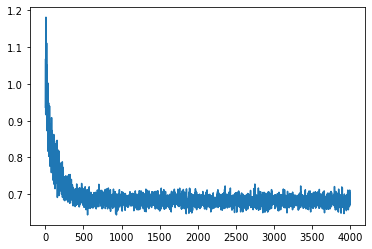

In [101]:
import matplotlib.pyplot as plt
plt.plot(glosses)

In [141]:
reduced_df.sample(5)

,date,polarity,query,text,user,bin_polarity,split_words,txt_length
189562,b'Wed Jun 03 02:05:40 PDT 2009',0,b'NO_QUERY',b'@Shikha_M yeah do...but its hacked ',b'Pro_94JBIT',0,"[@Shikha_M, yeah, do...but, its, hacked]",5
75941,b'Mon Jun 15 15:14:00 PDT 2009',0,b'NO_QUERY',b'@radadams Do want ',b'Mayeh',0,"[@radadams, Do, want]",3
88864,b'Sun Jun 21 01:14:59 PDT 2009',0,b'NO_QUERY',"b""I don't get it at all """,b'jodeeluv',0,"[I, don't, get, it, at, all]",6
39095,b'Fri May 29 12:41:21 PDT 2009',4,b'NO_QUERY',b'@PixyStixKitten The Last Unicorn...one of my...,b'rangerlyn',1,"[@PixyStixKitten, The, Last, Unicorn...one, of...",7
157169,b'Sat Jun 06 22:57:06 PDT 2009',4,b'NO_QUERY',b'listening to anberlin and passsing out ',b'ticklemexmik',1,"[listening, to, anberlin, and, passsing, out]",6


---
##### Let's try word embedding to see if this improves

We can use pre-made word embedding vectors from glove, which has 400,000 words

In [20]:
file = '/users/jacoblourie/RNN_games/glove.6B.50d.txt'
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [21]:
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(file)

--- 
We want to pass a list of words to a function, which maps them to the word embedding vectors, pads those vectors out and passes them to a RNN

let's look an example list of words

In [51]:
import string

In [171]:
sample_list = df.loc[1]['split_words']
#create a blank vector with 50 dims for the embedding dims, 30 time series slots, and 1 example
t_vs = 30
m_vs = 1
def create_embedding_vecs(wordlist, t, m,norm):
    x_embed_vec = np.zeros((50,t)) 
    x_embed_mask = np.zeros((t,)) + 1

    for word_idx in range(t):
        #check the word exists
        if (word_idx < len(wordlist)):
            if wordlist[word_idx] in words_to_index.keys():
                x_embed_vec[:,word_idx] = word_to_vec_map[wordlist[word_idx]]
                if norm==True:
                    x_embed_vec[:,word_idx] = x_embed_vec[:,word_idx] / np.sum(x_embed_vec[:,word_idx])
                x_embed_mask[word_idx] = 0

    return x_embed_vec, x_embed_mask

In [173]:
x_sample_vec, x_sample_mask = create_embedding_vecs(sample_list, t_vs, m_vs,norm=True)

In [176]:
def create_embed_batch(df,n,k,t, norm=True):
    m = k-n #examples is last index minus firsti ndex
    x_sample_multi = df.loc[n:k]['split_words']
    x_array_emb = np.zeros((50,t, m))
    x_array_emb_mask = np.zeros((t,m))
    for i in range(m):
        x_array_emb[:,:,i], x_array_emb_mask[:,i] = create_embedding_vecs(x_sample_multi.iloc[i],t,1,norm)
    return x_array_emb, x_array_emb_mask

In [294]:
x_array_emb_s, x_array_emb_mask = create_embed_batch(df,300,310,t_vs)

---
We can now put this into our RNN model using the functions defined earlier

In [165]:
x_array_emb_s.shape

(50, 30, 290)

In [355]:
'''set some initial parameters'''
epochs = 5000
cell_size = 64
x_size = 50
batches=1000

loss_reporting_frequency = 500
Tx = 30
train_size = 90000
df_train = df.loc[:train_size-1,:]
Y_train = Y[:train_size]
df_val = df.loc[train_size:,:]
Y_train = Y[:,:train_size]
Y_val = Y[:,train_size:]
batch_size = int(train_size//batches) #so 400

In [356]:
df_val.shape

(10000, 8)

In [313]:
WAx, WAb, WAa, WYa, WYb, weights_dict, z_dict, a_dict, losses, accs, ys, y_hats = RNN_init(cell_size,x_size)        
for epoch in range(epochs):
    n, k = batching_rnn(epoch,batches,batch_size) #create batching indexes

    #get specific x, x_mask and y values
    x, mask_x_ = create_embed_batch(df_train,n,k,Tx)
    #normalize x
    y = Y_train[0,n:k]
    
    #run fw prop
    z_dict, a_dict, Yz, Ÿ = full_fw_prop(Tx = Tx, z_dict=z_dict, a_dict=a_dict, weights_dict = weights_dict, x=x,mask=mask_x_)
    
    #append metrics and print loss if relevant
    get_loss_metrics_rnn(y,Ÿ, batch_size, epoch, loss_reporting_frequency)
    
    #run backprop
    dL_dZ, dZ_dA, dZ_dB, dL_dA, dL_dWYa, dL_dWYb, dL_dWAa, dL_dWAx, dL_dWAb, dL_dAp = back_prop_full_swing(Ÿ=Ÿ, Y=y, Tx=Tx, weights_dict=weights_dict,  a_dict=a_dict,z_dict=z_dict,  X=x, mask_x=mask_x_,learning_rate = 0.1,batch_size = batch_size)

Accuracy score: 0.5888888888888889
Epoch: 0, loss: 0.7665295146433962
Accuracy score: 0.5482295482295482
Epoch: 500, loss: 0.7093246022770234
Accuracy score: 0.5494505494505494
Epoch: 1000, loss: 0.7032911199154587
Accuracy score: 0.5548229548229549
Epoch: 1500, loss: 0.7114733799116136
Accuracy score: 0.5526251526251525
Epoch: 2000, loss: 0.705931443217046
Accuracy score: 0.5564102564102564
Epoch: 2500, loss: 0.7105278292142672
Accuracy score: 0.550915750915751
Epoch: 3000, loss: 0.7104358544807152
Accuracy score: 0.5567765567765568
Epoch: 3500, loss: 0.7095163910444275
Accuracy score: 0.5487179487179487
Epoch: 4000, loss: 0.7139658722160506


KeyboardInterrupt: 

---
Definite improvement. let's try it once in the GRU before seeing if keras gives significantly better results

In [219]:
tuple_of_outcomes_emb = gru_train(epochs=5000, cell_size=cell_size, voc_size=50,batch_size=50,
                                                   no_words=50,lr=0.01, Y=Y, array_x=df, Tx=Tx,reporting_freq=300,arr_or_df='df',
                                                  normed_emb=False)

Accuracy score: 0.51
Epoch: 0, loss: 0.9784587262714
Accuracy score: 0.5145544554455445
Epoch: 300, loss: 0.7942555523586107
Accuracy score: 0.521980198019802
Epoch: 600, loss: 0.776554894255418
Accuracy score: 0.5374257425742575
Epoch: 900, loss: 0.7577297310385734
Accuracy score: 0.5341584158415841
Epoch: 1200, loss: 0.7466458172638891
Accuracy score: 0.548910891089109
Epoch: 1500, loss: 0.7165238863880101
Accuracy score: 0.5543564356435644
Epoch: 1800, loss: 0.6742760376924564
Accuracy score: 0.5608910891089111
Epoch: 2100, loss: 0.705647581754989
Accuracy score: 0.5658415841584158
Epoch: 2400, loss: 0.6839740333863059
Accuracy score: 0.5662376237623763
Epoch: 2700, loss: 0.6956065426850402
Accuracy score: 0.5757425742574258
Epoch: 3000, loss: 0.6797512969553862
Accuracy score: 0.5764356435643564
Epoch: 3300, loss: 0.6907146836596273
Accuracy score: 0.5724752475247525
Epoch: 3600, loss: 0.6670357397098665
Accuracy score: 0.5797029702970297
Epoch: 3900, loss: 0.6651372696777432
Accur

--- OK we seem to have the best results with the simple RNN and the word embedding. let's try that in a validation set

In [ ]:
Y_val

In [358]:
df_val.shape

(10000, 8)

In [366]:
###do validation
n=0
k=5000
x_val, mask_x_val = create_embed_batch(df_val.reset_index(),n,k,Tx,norm=False)
y = Y_val[:,n:k]
z_dict, a_dict, Yz, Ÿ = full_fw_prop(Tx = Tx, z_dict=z_dict, a_dict=a_dict, weights_dict = weights_dict, x=x_val,mask=mask_x_val)
print(f'Validation score: {np.mean(y==np.where(Ÿ>0.5,1,0))}')

Validation score: 0.543


In [346]:
Y_train.shape

(1, 90000)

In [339]:
-np.sum(Y_val*np.log(Ÿ) + (1-Y_val)*np.log(1-Ÿ)) / 10000

0.7146337065083485

---
Now let's compare these results to what we can achieve in tensorflow, including using an LSTM and stacked LSTM model

In [253]:
import tensorflow

In [269]:
from tensorflow.keras.layers import Embedding, LSTM, RNN, GRU, SimpleRNN, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform


In [251]:
df_size=100000
vocab_size = 400001
emb_dim = 50
Tx = 30

In [250]:
#convert sentences to array of indices
df['words_by_idx'] = df['split_words'].apply(lambda x: np.array([words_to_index[y] for y in x if y in words_to_index.keys()]))

#turn it into a big array
x_array_keras = np.zeros((df_size,30))
for idx, wordlist in enumerate(df['words_by_idx']):
    for t in range(Tx):
        if t < len(wordlist):
            x_array_keras[idx,t] = wordlist[t]

In [258]:
#now create embedding layer
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, idx in words_to_index.items():
    emb_matrix[idx, :] = word_to_vec_map[word]

#create embedding layer
embedding_layer = Embedding(vocab_size,emb_dim,trainable=False)

embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
embedding_layer.set_weights([emb_matrix])

In [285]:
sentence_indices = Input(shape=(Tx),dtype='int32')
    
# Create the embedding layer pretrained with GloVe Vectors (≈1 line)

embeddings = embedding_layer(sentence_indices)   

X = SimpleRNN(units=120,return_sequences=False,kernel_initializer='glorot_uniform')(embeddings)

X = Dense(units=1,activation='sigmoid',kernel_initializer='glorot_uniform')(X)

# Create Model instance which converts sentence_indices into X.
model = Model(inputs=sentence_indices, outputs=X)


In [286]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [287]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 50)            20000050  
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 120)               20520     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 121       
Total params: 20,020,691
Trainable params: 20,641
Non-trainable params: 20,000,050
_________________________________________________________________


In [288]:
model.fit(x=x_array_keras,y=Y.reshape(-1,1),validation_split=0.2, batch_size=100,epochs=10)

Epoch 1/10
800/800 [==============================] - 9s 10ms/step - loss: 0.6565 - accuracy: 0.6143 - val_loss: 0.6064 - val_accuracy: 0.6745
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.6165 - accuracy: 0.6672 - val_loss: 0.6060 - val_accuracy: 0.6808
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.6079 - accuracy: 0.6712 - val_loss: 0.5960 - val_accuracy: 0.6862
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.5977 - accuracy: 0.6823 - val_loss: 0.5878 - val_accuracy: 0.6741
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.5861 - accuracy: 0.6908 - val_loss: 0.5811 - val_accuracy: 0.6991
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.5824 - accuracy: 0.6988 - val_loss: 0.5958 - val_accuracy: 0.6836
Epoch 7/10
800/800 [==============================] - 9s 11ms/step - loss: 0.5687 - accuracy: 0.7071 - val_loss: 0.5730 - val_accuracy: 0.6959

--
We've already beaten the handmade model! let's try a couple more

In [289]:
#GRU
sentence_indices = Input(shape=(Tx),dtype='int32')
embeddings = embedding_layer(sentence_indices)   
X = GRU(units=120,return_sequences=False,kernel_initializer='glorot_uniform')(embeddings)
X = Dense(units=1,activation='sigmoid',kernel_initializer='glorot_uniform')(X)
model_GRU = Model(inputs=sentence_indices, outputs=X)
model_GRU.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics='accuracy')
model_GRU.fit(x=x_array_keras,y=Y.reshape(-1,1),validation_split=0.2, batch_size=100,epochs=10)

Epoch 1/10
800/800 [==============================] - 27s 33ms/step - loss: 0.6340 - accuracy: 0.6215 - val_loss: 0.5608 - val_accuracy: 0.7090
Epoch 2/10
800/800 [==============================] - 27s 34ms/step - loss: 0.5471 - accuracy: 0.7226 - val_loss: 0.5580 - val_accuracy: 0.7058
Epoch 3/10
800/800 [==============================] - 25s 31ms/step - loss: 0.5158 - accuracy: 0.7439 - val_loss: 0.5054 - val_accuracy: 0.7506
Epoch 4/10
800/800 [==============================] - 26s 32ms/step - loss: 0.4935 - accuracy: 0.7610 - val_loss: 0.4918 - val_accuracy: 0.7646
Epoch 5/10
800/800 [==============================] - 25s 31ms/step - loss: 0.4773 - accuracy: 0.7735 - val_loss: 0.4867 - val_accuracy: 0.7683
Epoch 6/10
800/800 [==============================] - 26s 32ms/step - loss: 0.4622 - accuracy: 0.7818 - val_loss: 0.4786 - val_accuracy: 0.7713
Epoch 7/10
800/800 [==============================] - 25s 31ms/step - loss: 0.4506 - accuracy: 0.7892 - val_loss: 0.5069 - val_accuracy:

In [290]:
#LSTM
sentence_indices = Input(shape=(Tx),dtype='int32')
embeddings = embedding_layer(sentence_indices)   
X = LSTM(units=120,return_sequences=False,kernel_initializer='glorot_uniform')(embeddings)
X = Dense(units=1,activation='sigmoid',kernel_initializer='glorot_uniform')(X)
model_LSTM = Model(inputs=sentence_indices, outputs=X)
model_LSTM.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics='accuracy')
model_LSTM.fit(x=x_array_keras,y=Y.reshape(-1,1),validation_split=0.2, batch_size=100,epochs=10)

Epoch 1/10
800/800 [==============================] - 32s 38ms/step - loss: 0.6195 - accuracy: 0.6569 - val_loss: 0.5645 - val_accuracy: 0.7067
Epoch 2/10
800/800 [==============================] - 32s 39ms/step - loss: 0.5577 - accuracy: 0.7170 - val_loss: 0.5447 - val_accuracy: 0.7192
Epoch 3/10
800/800 [==============================] - 30s 37ms/step - loss: 0.5303 - accuracy: 0.7363 - val_loss: 0.5201 - val_accuracy: 0.7400
Epoch 4/10
800/800 [==============================] - 34s 42ms/step - loss: 0.5090 - accuracy: 0.7495 - val_loss: 0.5130 - val_accuracy: 0.7567
Epoch 5/10
800/800 [==============================] - 30s 38ms/step - loss: 0.4916 - accuracy: 0.7632 - val_loss: 0.5021 - val_accuracy: 0.7516
Epoch 6/10
800/800 [==============================] - 31s 39ms/step - loss: 0.4777 - accuracy: 0.7711 - val_loss: 0.4912 - val_accuracy: 0.7612
Epoch 7/10
800/800 [==============================] - 31s 39ms/step - loss: 0.4571 - accuracy: 0.7851 - val_loss: 0.4875 - val_accuracy:

---
Significantly better performance with Keras. This could be down to the optimizer, the initialization method, or it could be a mathematical error in the formula! 

GRU bas performed the best, with little overfitting. Let's add another stacked layer and see if we can get a further improvement

In [291]:
sentence_indices = Input(shape=(Tx),dtype='int32')
embeddings = embedding_layer(sentence_indices)   
X = GRU(units=120,return_sequences=True,kernel_initializer='glorot_uniform')(embeddings)
X = GRU(units=64,return_sequences=True,kernel_initializer='glorot_uniform')(X)
X = Dense(units=1,activation='sigmoid',kernel_initializer='glorot_uniform')(X)
model_GRU = Model(inputs=sentence_indices, outputs=X)
model_GRU.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics='accuracy')
model_GRU.fit(x=x_array_keras,y=Y.reshape(-1,1),validation_split=0.2, batch_size=100,epochs=10)

Epoch 1/10
800/800 [==============================] - 35s 41ms/step - loss: 0.6307 - accuracy: 0.6369 - val_loss: 0.5702 - val_accuracy: 0.6987
Epoch 2/10
800/800 [==============================] - 29s 36ms/step - loss: 0.5638 - accuracy: 0.7036 - val_loss: 0.5460 - val_accuracy: 0.7188
Epoch 3/10
800/800 [==============================] - 38s 47ms/step - loss: 0.5387 - accuracy: 0.7223 - val_loss: 0.5284 - val_accuracy: 0.7297
Epoch 4/10
800/800 [==============================] - 35s 43ms/step - loss: 0.5226 - accuracy: 0.7350 - val_loss: 0.5494 - val_accuracy: 0.7161
Epoch 5/10
800/800 [==============================] - 35s 43ms/step - loss: 0.5089 - accuracy: 0.7435 - val_loss: 0.5220 - val_accuracy: 0.7349
Epoch 6/10
800/800 [==============================] - 32s 40ms/step - loss: 0.4967 - accuracy: 0.7529 - val_loss: 0.5199 - val_accuracy: 0.7410
Epoch 7/10
800/800 [==============================] - 33s 41ms/step - loss: 0.4840 - accuracy: 0.7606 - val_loss: 0.5099 - val_accuracy:

---
It doesn't improve things.

The next steps will be to try some hyperparameter tuning and increase the dataset size